# Capstone project

For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

# Introduction

For this capstone project we will be using a dataset of newspaper articles found on Kaggle, taken from a wide variety of news sources. We will choose a subset of text consisting of 200 articles, with 10 different authors. Each author's corpus will contain 20 articles.

https://www.kaggle.com/snapcrack/all-the-news

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import json
from time import time
from collections import Counter
from sklearn import ensemble
from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation, SpectralClustering, MeanShift, estimate_bandwidth

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, log_loss, make_scorer, normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize, normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import scikitplot.plotters as skplt

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

stopwords = stopwords.words('english')

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

Numpy version: 1.16.4
Pandas version: 0.23.4
Seaborn version: 0.9.0


# Data Exploration

In [2]:
df = pd.read_csv('datasets/all-the-news/articles1.csv')
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [3]:
df.isnull().sum()

Unnamed: 0         0
id                 0
title              0
publication        0
author          6306
date               0
year               0
month              0
url            50000
content            0
dtype: int64

Let's drop unnecessary columns.

In [4]:
df = df.drop(['Unnamed: 0', 'url'], axis=1)
df.head()

,id,title,publication,author,date,year,month,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ..."


Check for null values.

In [5]:
df.isnull().sum()

id                0
title             0
publication       0
author         6306
date              0
year              0
month             0
content           0
dtype: int64

In [6]:
df = df.dropna()
df.head()

,id,title,publication,author,date,year,month,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,"SEOUL, South Korea — North Korea’s leader, ..."


In [7]:
df.isnull().sum()

id             0
title          0
publication    0
author         0
date           0
year           0
month          0
content        0
dtype: int64

Let's take a look at the distribution of article lengths, in characters.

Statistical Summary of Article Lengths
count     43694.000000
mean       3853.685197
std        3894.493670
min           1.000000
25%        1672.000000
50%        2810.500000
75%        5046.750000
max      149346.000000
dtype: float64


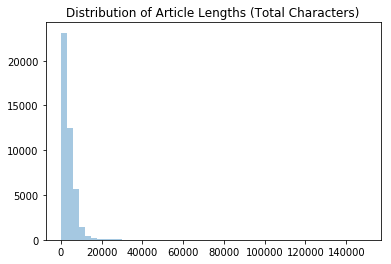

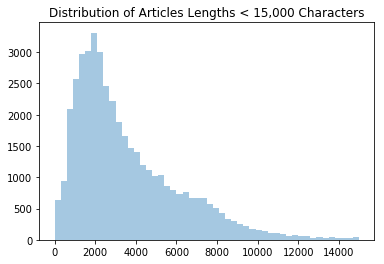

0     5607
1    27834
2    14018
3    12274
4     4195
dtype: int64

In [8]:
lengths = pd.Series([len(x) for x in df.content])
print('Article Length Statistics')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (Total Characters)')
plt.show()

sns.distplot(lengths[lengths < 15000], kde=False)
plt.title('Distribution of Articles Lengths < 15,000 Characters')
plt.show()
lengths.head()

# Data Selection

We will select 10 authors (with 20 articles each) for our overall text corpus, and save it to a DataFrame.

In [9]:
# First 10 authors with more than 20 articles
print(df.author.value_counts()[df.author.value_counts()>20][-10:])

The Associated Press    21
Patrick Healy           21
Nicholas Fandos         21
Ashley Strickland       21
Max Fisher              21
Ben Shapiro             21
Carl Hulse              21
Victor Mather           21
Amanda Jackson          21
Dennis Green            21
Name: author, dtype: int64


In [10]:
# Make a DataFrame with articles by our chosen authors
# Include author names and article titles

# Make a list of the 10 chosen author names
names = df.author.value_counts()[df.author.value_counts() > 20][-10:].index.tolist()

print(names)

# DataFrame for articles of all chosen authors
data = pd.DataFrame()
for name in names:
    # Select each author's data
    articles = df[df.author == name][:20][['title', 'content', 'author']]
    # Append data to DataFrame
    data = data.append(articles)

data = data.reset_index().drop('index', 1)

['The Associated Press', 'Patrick Healy', 'Nicholas Fandos', 'Ashley Strickland', 'Max Fisher', 'Ben Shapiro', 'Carl Hulse', 'Victor Mather', 'Amanda Jackson', 'Dennis Green']


Let's make sure we have 200 articles total and 20 articles per author.

In [11]:
# Check for duplicates
print('Total articles:', data.shape[0])
print('Unique articles:', len(np.unique(data.index)))

# Number of authors
print('Unique authors:', len(np.unique(data.author)))
print('')
print('Articles by author:\n')

# Article counts by author
print(data.author.value_counts())

Total articles: 200
Unique articles: 200
Unique authors: 10

Articles by author:

Nicholas Fandos         20
Ashley Strickland       20
Patrick Healy           20
Carl Hulse              20
Dennis Green            20
Ben Shapiro             20
Max Fisher              20
Amanda Jackson          20
The Associated Press    20
Victor Mather           20
Name: author, dtype: int64


# Feature Engineering
Now we can proceed with feature engineering. We will combine each author's set of articles into a separate corpus and run spacy on these documents. 

In [12]:
start_time = time()

# Load spacy NLP object
nlp = spacy.load('en')

# A list to store common words by all authors
common_words = []

# A dictionary to store each author's spacy_doc object
authors_docs = {}

for name in names:
    # Corpus is all text written by a single author
    corpus = ""
    
    # Grab all text of current author, along 'content' column
    author_content = data.loc[data.author == name, 'content']
    
    # Add each article to overall corpus
    for article in author_content:
        corpus = corpus + article
        
    # Clean corpus and parse using Spacy
    doc = nlp(corpus)
    
    # Store doc in dictionary
    authors_docs[name] = doc
        
    # Remove punctuation and stop words
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
        
    # Return most common words of that author's corpus
    bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
    # Add them to the list of common words
    for word in bow:
        common_words.append(word)

# Remove duplicates
common_words = set(common_words)
    
print('Total number of common words:', len(common_words))
print("Completed in %0.3fs" % (time() - start_time))

Total number of common words: 4439
Completed in 34.169s


In [13]:
# Let's see how many words per author
lengths = []
for k,v in authors_docs.items():
    print(k,'corpus has', len(v), ' words.')
    lengths.append(len(v))

The Associated Press corpus has 10347  words.
Patrick Healy corpus has 30286  words.
Nicholas Fandos corpus has 20684  words.
Ashley Strickland corpus has 23623  words.
Max Fisher corpus has 31833  words.
Ben Shapiro corpus has 20926  words.
Carl Hulse corpus has 22804  words.
Victor Mather corpus has 15589  words.
Amanda Jackson corpus has 8971  words.
Dennis Green corpus has 7465  words.


Let's plot a histogram of word counts for each author's corpus.

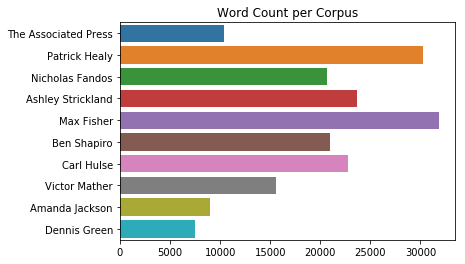

In [42]:
sns.barplot(x=lengths, y=names, orient='h')
plt.title('Word Count per Corpus')
plt.show()

In [15]:
# Check for lowercase words
common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
print('Total common words: ', len(common_words))
print('Total lowercase common words: ', np.sum([word.islower() for word in common_words]))

# Make all common words lowercase
common_words = [word.lower() for word in common_words]
print('Total lowercase common words (after converting): ', np.sum([word.islower() for word in common_words]))

Total common words:  4439
Total lowercase common words:  3151
Total lowercase common words (after converting):  4323


In [16]:
# Remove words that might conflict with new features
if 'author' in common_words:
    common_words.remove('author')
if 'title' in common_words:
    common_words.remove('title')
if 'content' in common_words:
    common_words.remove('content')

Now we can create a DataFrame, bow_counts, to store our bag-of-words counts for each article. This section takes the longest amount of time to process; runtime to populate the DataFrame is at least 30 minutes.

In [17]:
# Count how many times a common word appears in each article
bow_counts = pd.DataFrame()
for name in names:
    # Select 20 articles for each author
    articles = data.loc[data.author==name,:][:20]
    # Append articles to BOW dataframe
    bow_counts = bow_counts.append(articles)
bow_counts = bow_counts.reset_index().drop('index',1)

# Use common_words as the columns of a temporary DataFrame
df = pd.DataFrame(columns=common_words)

# Join BOW features with the author's content
bow_counts = bow_counts.join(df)

# Initialize rows with zeroes
bow_counts.loc[:,common_words] = 0

# Populate DataFrame with counts of every feature per article
start_time = time()
for i, article in enumerate(bow_counts.content):
    doc = nlp(article)
    for token in doc:
        # If lowercase word is found in common words, increment its BOW count
        if token.lemma_.lower() in common_words:
            bow_counts.loc[i,token.lemma_.lower()] += 1
    # Print a message every 20 articles
    if i % 20 == 0:
        if time()-start_time < 3600: # if less than an hour in seconds
            print('Article ', i, ' completed after ', (time()-start_time)/60,' minutes.')
        else:
            print('Article ', i, ' completed after ', (time()-start_time)/60/60,' hours.')

Article  0  completed after  0.12733921607335408  minutes.
Article  20  completed after  1.818984035650889  minutes.
Article  40  completed after  6.882728366057078  minutes.
Article  60  completed after  9.902668384710948  minutes.
Article  80  completed after  13.618896865844727  minutes.
Article  100  completed after  17.989202666282655  minutes.
Article  120  completed after  20.783625400066377  minutes.
Article  140  completed after  24.134114782015484  minutes.
Article  160  completed after  25.929486453533173  minutes.
Article  180  completed after  27.064962633450826  minutes.


In [18]:
bow_counts.head(3)

,title,content,author,commit,macaroni,reminder,jersey,rational,agenda,habitable,...,afternoon,bomber,continue,south,|,bread,keeping,mps,plaza,tournament
0,Suicide Bombing in Baghdad Kills at Least 36 -...,BAGHDAD — A suicide bomber detonated a pick...,The Associated Press,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
1,Brock Osweiler and Texans Knock the Battered R...,HOUSTON — Follow our live N. F. L. playoffs...,The Associated Press,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bernie Ecclestone Is Replaced as Formula One C...,LONDON — Bernie Ecclestone’s longstanding l...,The Associated Press,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Set target and features
y = bow_counts['author']
X = bow_counts.drop(['content','author','title'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [20]:
# Store overall results in two separate DataFrames
clust_metrics = ['Algorithm', 'Dataset', 'Sample Size', 'ARI', 'Silhouette']
model_metrics = ['Algorithm', 'ARI', 'Cross-validation', 'Train Accuracy', 'Test Accuracy']

results_clust = pd.DataFrame(columns=clust_metrics)
results_model = pd.DataFrame(columns=model_metrics)

# Clustering
We will evaluate three separate clustering algorithms: K-Means, Mean-shift, and Affinity Propagation. We will do these for the train and test sets, separately. First, we can use the elbow method plot to get a rough idea of the optimal number of clusters for K-Means.
## Find Optimal Clusters

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


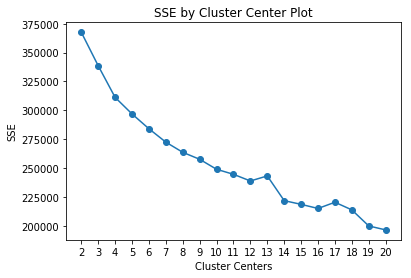

In [21]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=42).fit(data).inertia_)
        print('{} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center')
    
find_optimal_clusters(X_train, 20)

It is difficult to tell where the true elbow lies in the graph above. There appear to be multiple elbows at 8, 11, and 14 clusters. We can use GridSearchCV to help us estimate the optimal parameters for our clustering algorithm, including the optimal number of clusters. Let's create a function to run our clustering algorithms and save the results in a DataFrame. Then we will run this separately for the train and test sets, for each model.

In [22]:
# Function to quickly evaluate clustering solutions
def evaluate_cluster(data, target, clust, params, dataset, i):
    start_time = time()
    print('\n','-'*50,'\n',clust.__class__.__name__,'\n','-'*50)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(adjusted_rand_score)
    search = GridSearchCV(clust, params, scoring=score, cv=5).fit(data, target)
    print("Best parameters:", search.best_params_)
    y_pred = search.best_estimator_.fit_predict(data)

    ari = adjusted_rand_score(target, y_pred)
    results_clust.loc[i, 'ARI'] = ari 
    print("Adjusted Rand-Index: %.3f" % ari)
    
    sil = silhouette_score(data, y_pred)
    results_clust.loc[i, 'Silhouette'] = sil
    print("Silhouette Score: %.3f" % sil)
    
    results_clust.loc[i, 'Algorithm'] = clust.__class__.__name__
    results_clust.loc[i, 'Dataset'] = dataset
    results_clust.loc[i, 'Sample Size'] = len(data)
    
    # Print contingency matrix
    crosstab = pd.crosstab(target, y_pred)
    plt.figure(figsize=(10,5))
    sns.heatmap(crosstab, annot=True, fmt='d', cmap=plt.cm.winter)
    plt.show()
    print(time()-start_time, "seconds.")

## Train Set
### K-Means


 -------------------------------------------------- 
 KMeans 
 --------------------------------------------------
Best parameters: {'init': 'random', 'n_clusters': 25, 'n_init': 20, 'precompute_distances': True}
Adjusted Rand-Index: 0.145
Silhouette Score: 0.034


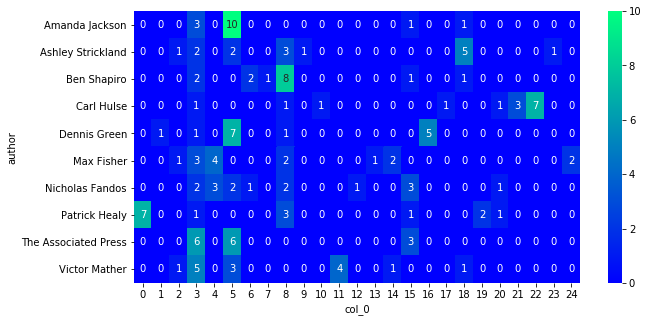

143.27607107162476 seconds.


In [23]:
clust = KMeans()
params={
    'n_clusters': np.arange(5, 30, 5),
    'init': ['k-means++','random'],
    'n_init': [10, 20],
    'precompute_distances':[True, False]
}
evaluate_cluster(X_train, y_train, clust, params, dataset='Train', i=0)

### Mean-shift


 -------------------------------------------------- 
 MeanShift 
 --------------------------------------------------
Best parameters: {}
Adjusted Rand-Index: 0.017
Silhouette Score: 0.160


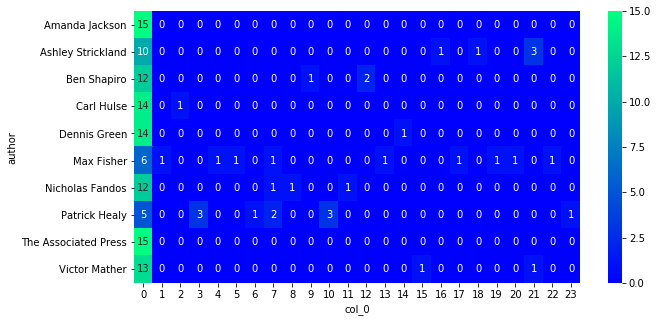

25.600823879241943 seconds.


In [24]:
#Declare and fit the model
clust = MeanShift()

params={}
evaluate_cluster(X_train, y_train, clust, params, dataset='Train', i=1)

### Affinity Propagation


 -------------------------------------------------- 
 AffinityPropagation 
 --------------------------------------------------
Best parameters: {'damping': 0.5, 'max_iter': 200}
Adjusted Rand-Index: 0.142
Silhouette Score: 0.100


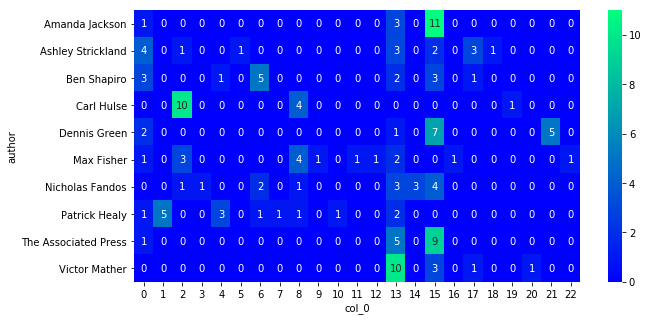

3.159169912338257 seconds.


In [25]:
#Declare and fit the model.
clust = AffinityPropagation()
params = {
    'damping': [0.5, 0.7, 0.9], 
    'max_iter': [200, 500]
}
evaluate_cluster(X_train, y_train, clust, params, dataset='Train', i=2)

## Test Set
### K-Means


 -------------------------------------------------- 
 KMeans 
 --------------------------------------------------
Best parameters: {'init': 'random', 'n_clusters': 15, 'n_init': 10, 'precompute_distances': True}
Adjusted Rand-Index: 0.247
Silhouette Score: 0.011


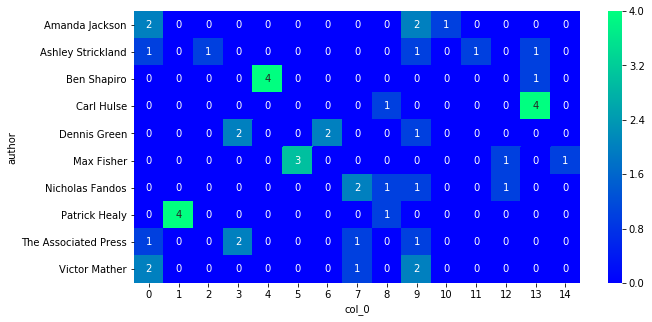

53.028088092803955 seconds.


In [26]:
clust = KMeans()
params={
    'n_clusters': np.arange(5, 30, 5),
    'init': ['k-means++','random'],
    'n_init': [10, 20],
    'precompute_distances':[True, False]
}
evaluate_cluster(X_test, y_test, clust, params, dataset='Test', i=3)

### Mean-shift


 -------------------------------------------------- 
 MeanShift 
 --------------------------------------------------
Best parameters: {}
Adjusted Rand-Index: 0.028
Silhouette Score: 0.200


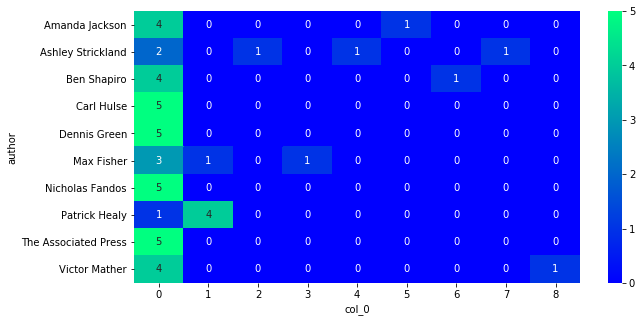

2.8528971672058105 seconds.


In [27]:
#Declare and fit the model
clust = MeanShift()

params={}
evaluate_cluster(X_test, y_test, clust, params, dataset='Test', i=4)

### Affinity Propagation


 -------------------------------------------------- 
 AffinityPropagation 
 --------------------------------------------------
Best parameters: {'damping': 0.9, 'max_iter': 200}
Adjusted Rand-Index: 0.096
Silhouette Score: 0.204


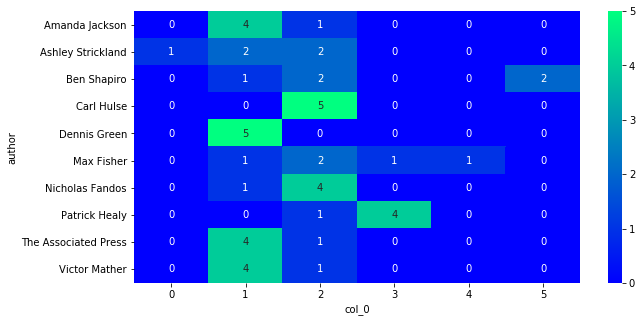

0.9539010524749756 seconds.


In [28]:
#Declare and fit the model.
clust = AffinityPropagation()
params = {
    'damping': [0.5, 0.7, 0.9], 
    'max_iter': [200, 500]
}
evaluate_cluster(X_test, y_test, clust, params, dataset='Test', i=5)

In [29]:
results_clust.iloc[:6].sort_values('ARI', ascending=False)

,Algorithm,Dataset,Sample Size,ARI,Silhouette
3,KMeans,Test,50,0.247031,0.0107759
0,KMeans,Train,150,0.145233,0.0342898
2,AffinityPropagation,Train,150,0.141887,0.0995408
5,AffinityPropagation,Test,50,0.0955434,0.20445
4,MeanShift,Test,50,0.0281253,0.199785
1,MeanShift,Train,150,0.0168168,0.160366


Our two best clustering solutions were K-Means, according to the ARI score. In fact, running K-Means on our test set gave us the highest ARI score. However, we are likely to get much higher ARI scores just from using supervised learning models. We can run one modeling iteration without a clustering feature added in, and then do another iteration with a clustering feature to indicate which cluster an article belongs to.

# Modeling
We can create a simple function to run our model and store results in a dataframe, which will allow us to easily compare results at the end.

In [30]:
def evaluate_model(clf, params, features, i):
    start_time = time()
    
    # Print classifier type
    print('\n', '-'*50, '\n', clf.__class__.__name__, '\n', '-'*50)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(adjusted_rand_score)
    search = GridSearchCV(clf, params, scoring=score, cv=5).fit(X, y)
    
    # Extract best estimator
    best = search.best_estimator_
    print("Best parameters:", search.best_params_)

    # Run cross-validation
    cv = cross_val_score(X=X, y=y,estimator=best, cv=5)
    print("\nCross-validation scores:", cv)
    print("\nMean cross-validation score:", cv.mean())
    results_model.loc[i, 'Cross-validation'] = cv.mean() 
    
    # Calculate training accuracy
    best = best.fit(X_train, y_train)
    train = best.score(X=X_train,y=y_train)
    results_model.loc[i, 'Train Accuracy'] = train 
    print("\nTrain Set Accuracy Score:", train)

    # Calculate test accuracy
    test = best.score(X=X_test, y=y_test)
    results_model.loc[i, 'Test Accuracy'] = test 
    print("\nTest Set Accuracy Score:", test)
    
    y_pred = best.predict(X_test)

    ari = adjusted_rand_score(y_test, y_pred)
    results_model.loc[i, 'ARI'] = ari 
    print("\nAdjusted Rand-Index: %.3f" % ari)
    
    print(classification_report(y_test, y_pred))

    conf_matrix = pd.crosstab(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.winter)
    plt.show()
    
    results_model.loc[i,'Data Size'] = len(X)
    results_model.loc[i,'Features'] = features
    results_model.loc[i,'Algorithm'] = clf.__class__.__name__
    print(time()-start_time, 'seconds.')

## Iteration 1: BoW Features
### Logistic Regression


 -------------------------------------------------- 
 LogisticRegression 
 --------------------------------------------------
Best parameters: {'C': 0.3, 'penalty': 'l2', 'solver': 'liblinear'}

Cross-validation scores: [0.825 0.8   0.8   0.825 0.7  ]

Mean cross-validation score: 0.79

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.82

Adjusted Rand-Index: 0.674
                      precision    recall  f1-score   support

      Amanda Jackson       0.67      0.80      0.73         5
   Ashley Strickland       0.80      0.80      0.80         5
         Ben Shapiro       1.00      1.00      1.00         5
          Carl Hulse       1.00      1.00      1.00         5
        Dennis Green       1.00      1.00      1.00         5
          Max Fisher       1.00      1.00      1.00         5
     Nicholas Fandos       0.67      0.80      0.73         5
       Patrick Healy       1.00      0.80      0.89         5
The Associated Press       0.50      0.20      0.29         5
 

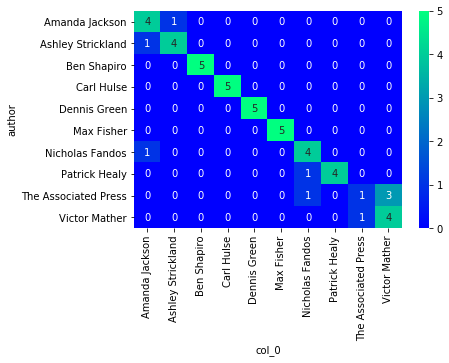

565.4562876224518 seconds.


In [31]:
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear', 'saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1', 'l2']
}]

clf = LogisticRegression(
    n_jobs=-1, # Use all CPU
    multi_class='auto'
)

evaluate_model(clf=clf, params=params, features='BOW', i=0)

### Random Forest Classifier


 -------------------------------------------------- 
 RandomForestClassifier 
 --------------------------------------------------
Best parameters: {'n_estimators': 20}

Cross-validation scores: [0.675 0.725 0.675 0.7   0.625]

Mean cross-validation score: 0.68

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.64

Adjusted Rand-Index: 0.429
                      precision    recall  f1-score   support

      Amanda Jackson       0.44      0.80      0.57         5
   Ashley Strickland       0.50      0.60      0.55         5
         Ben Shapiro       1.00      1.00      1.00         5
          Carl Hulse       0.62      1.00      0.77         5
        Dennis Green       0.71      1.00      0.83         5
          Max Fisher       0.80      0.80      0.80         5
     Nicholas Fandos       0.00      0.00      0.00         5
       Patrick Healy       0.80      0.80      0.80         5
The Associated Press       0.00      0.00      0.00         5
       Victor Mather       

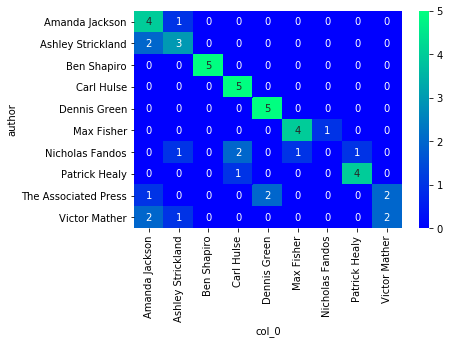

6.491629123687744 seconds.


In [32]:
params = [{
    'n_estimators': [10, 15, 20]
}]

clf = RandomForestClassifier(
    n_jobs=-1 # Use all CPU
)

evaluate_model(clf=clf, params=params, features='BOW', i=1)

### Gradient Boosting Classifier


 -------------------------------------------------- 
 GradientBoostingClassifier 
 --------------------------------------------------
Best parameters: {'max_depth': 2, 'n_estimators': 200}

Cross-validation scores: [0.8   0.725 0.775 0.725 0.8  ]

Mean cross-validation score: 0.765

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.84

Adjusted Rand-Index: 0.638
                      precision    recall  f1-score   support

      Amanda Jackson       1.00      0.80      0.89         5
   Ashley Strickland       0.83      1.00      0.91         5
         Ben Shapiro       1.00      1.00      1.00         5
          Carl Hulse       1.00      0.60      0.75         5
        Dennis Green       0.83      1.00      0.91         5
          Max Fisher       1.00      0.80      0.89         5
     Nicholas Fandos       0.62      1.00      0.77         5
       Patrick Healy       1.00      0.80      0.89         5
The Associated Press       0.62      1.00      0.77         5
     

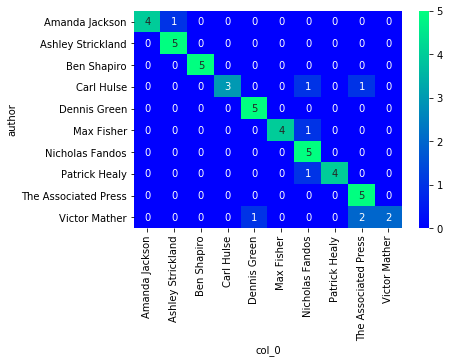

607.4600448608398 seconds.


In [33]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = [{
    'n_estimators': [200, 500],
    'max_depth': [2, 3, 4, 5]
}]

clf = ensemble.GradientBoostingClassifier()

evaluate_model(clf=clf, params=params, features='BOW', i=2)

## Iteration 2: BoW Features with Clustering Assignment
Let's compute our clusters using K-Means with the optimal set of parameters determined above. Then we can add this as another feature to our original dataset.

In [34]:
# Calculate predicted values.
clusters_train = KMeans(init='random', n_clusters=15, n_init=20, precompute_distances=False).fit_predict(X_train)
clusters_test = KMeans(init='k-means++', n_clusters=25, n_init=10, precompute_distances=False).fit_predict(X_test)
print(clusters_train)
print(clusters_test)

[ 4  2  2  4  2  5  4  6  6  8  3  7 14 10  0  0  4  5  6  5  5 14 14 10
 12  4  5  5  0  4 10  5 14  2  5  2  2 14  5 14  1  4  0 14 10  4 14  2
 10  5  6  2 12  1  8  5  4 11  6  9  0  9 14  6  6 14  9  4 14  3 14 14
 14 12  4 12 13  2  4 14  4  2  6  2  5 14  4  5  2  0  4  2  9 14 14 12
 14  4 10  4  2  6  5  6 10  5 14 10  4  5  2  2  5  7 14  2  9  5  2  4
  0  8  8  5  2  3  0  0 14 14 14  2  4 10  4  4  5 14 10 10 10  0 14 14
  4  8  2  4  1  5]
[ 2  2 23  4  8 16  2 23 23  3 20 24 12  2  7 22 15  5  4  5 23  1 24  6
  2  2  2 23 10 16  0 23 18 21 16 23 23 13 19  2 17 12 11 19  2 24  9 13
  2 14]


In [35]:
X_train['cluster_assignment'] = list(clusters_train)
X_train.head()

/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,commit,macaroni,reminder,jersey,rational,agenda,habitable,budget,sovereignty,elliott,...,bomber,continue,south,|,bread,keeping,mps,plaza,tournament,cluster_assignment
150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
198,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
71,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
188,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [36]:
X_test['cluster_assignment'] = list(clusters_test)
X_test.head()

/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,commit,macaroni,reminder,jersey,rational,agenda,habitable,budget,sovereignty,elliott,...,bomber,continue,south,|,bread,keeping,mps,plaza,tournament,cluster_assignment
153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23
53,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4
65,0,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,8


### Logistic Regression


 -------------------------------------------------- 
 LogisticRegression 
 --------------------------------------------------
Best parameters: {'C': 0.3, 'penalty': 'l2', 'solver': 'liblinear'}

Cross-validation scores: [0.825 0.8   0.8   0.825 0.7  ]

Mean cross-validation score: 0.79

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.86

Adjusted Rand-Index: 0.720
                      precision    recall  f1-score   support

      Amanda Jackson       0.75      0.60      0.67         5
   Ashley Strickland       0.71      1.00      0.83         5
         Ben Shapiro       1.00      1.00      1.00         5
          Carl Hulse       1.00      1.00      1.00         5
        Dennis Green       1.00      1.00      1.00         5
          Max Fisher       1.00      1.00      1.00         5
     Nicholas Fandos       0.71      1.00      0.83         5
       Patrick Healy       1.00      0.80      0.89         5
The Associated Press       0.67      0.40      0.50         5
 

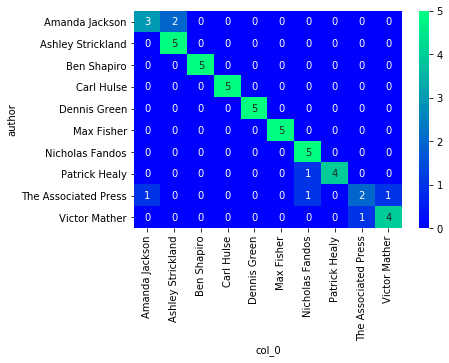

626.636766910553 seconds.


In [37]:
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear', 'saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1', 'l2']
}]

clf = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

evaluate_model(clf=clf, params=params, features='BOW & Clust', i=3)

### Random Forest Classifier


 -------------------------------------------------- 
 RandomForestClassifier 
 --------------------------------------------------
Best parameters: {'n_estimators': 20}

Cross-validation scores: [0.675 0.775 0.75  0.725 0.65 ]

Mean cross-validation score: 0.7150000000000001

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.68

Adjusted Rand-Index: 0.445
                      precision    recall  f1-score   support

      Amanda Jackson       0.38      0.60      0.46         5
   Ashley Strickland       1.00      0.60      0.75         5
         Ben Shapiro       1.00      1.00      1.00         5
          Carl Hulse       0.83      1.00      0.91         5
        Dennis Green       0.62      1.00      0.77         5
          Max Fisher       0.62      1.00      0.77         5
     Nicholas Fandos       1.00      0.40      0.57         5
       Patrick Healy       0.75      0.60      0.67         5
The Associated Press       0.00      0.00      0.00         5
       Victor

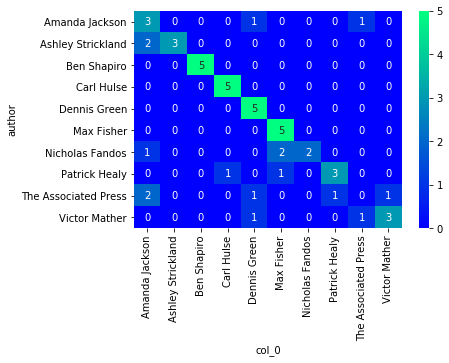

8.67391586303711 seconds.


In [38]:
params = [{
    'n_estimators': [10, 15, 20]
}]

clf = RandomForestClassifier(
    n_jobs=-1 # Use all CPU
)

evaluate_model(clf=clf, params=params, features='BOW & Clust', i=4)

### Gradient Boosting Classifier


 -------------------------------------------------- 
 GradientBoostingClassifier 
 --------------------------------------------------
Best parameters: {'max_depth': 2, 'n_estimators': 500}

Cross-validation scores: [0.75  0.75  0.775 0.725 0.75 ]

Mean cross-validation score: 0.75

Train Set Accuracy Score: 1.0

Test Set Accuracy Score: 0.86

Adjusted Rand-Index: 0.678
                      precision    recall  f1-score   support

      Amanda Jackson       1.00      0.80      0.89         5
   Ashley Strickland       1.00      1.00      1.00         5
         Ben Shapiro       1.00      1.00      1.00         5
          Carl Hulse       1.00      0.60      0.75         5
        Dennis Green       0.83      1.00      0.91         5
          Max Fisher       1.00      1.00      1.00         5
     Nicholas Fandos       0.71      1.00      0.83         5
       Patrick Healy       1.00      0.80      0.89         5
The Associated Press       0.56      1.00      0.71         5
      

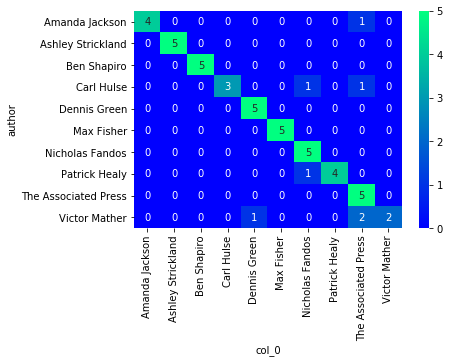

696.6624248027802 seconds.


In [39]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = [{
    'n_estimators': [200, 500],
    'max_depth': [2, 3, 4, 5]
}]

clf = ensemble.GradientBoostingClassifier()

evaluate_model(clf=clf, params=params, features='BOW & Clust', i=5)

In [40]:
results_model.iloc[:6].sort_values('ARI', ascending=False)

,Algorithm,ARI,Cross-validation,Train Accuracy,Test Accuracy,Data Size,Features
3,LogisticRegression,0.720362,0.79,1.0,0.86,200.0,BOW & Clust
5,GradientBoostingClassifier,0.677963,0.75,1.0,0.86,200.0,BOW & Clust
0,LogisticRegression,0.674314,0.79,1.0,0.82,200.0,BOW
2,GradientBoostingClassifier,0.637708,0.765,1.0,0.84,200.0,BOW
4,RandomForestClassifier,0.445063,0.715,1.0,0.68,200.0,BOW & Clust
1,RandomForestClassifier,0.429362,0.68,1.0,0.64,200.0,BOW


Logistic Regression with the 'BOW & Clust' set of features was our best model, obtaining the highest ARI score at 0.72 as well as the highest test set accuracy score of 0.86. Gradient Boosting Classifier with the 'BOW & Clust' features wasn't too far behind with an ARI of 0.68 and test set accuracy score of 0.86. Most notably, our two best models were those using the clustering assignment feature added in. Interestingly, our train set accuracy was 1.0 for every model. Though not ideal, this result is predictable due to the sample size being only 200 articles; it indicates overfitting.

Unfortunately, adding the clustering feature didn't fix the overfitting, although it did increase our test set accuracy by 0.04, which is sizable. A much larger sample size and perhaps more rigorous feature engineering is needed to get a more realistic train set accuracy score, although our test set accuracy scores are already reasonable enough. The dropoff from train set accuracy to test set accuracy is not terribly steep, so this is likely just a sample size issue. Due to the intensive nature of NLP, increasing the sample size of articles used even by a small amount may greatly increase the preprocessing time, which already takes about an hour.